# Project: Trump, Twitter, and Text

In this project, I am working with the Twitter API to scrape and analyze Donald Trump's tweets.

In [62]:
# Notebook setup
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

from IPython.display import display, Latex, Markdown



<br/><br/><br/>

# Getting the dataset

---

To get Twitter data, we will download it using the API for large batches. We use the `tweepy` package.

In [4]:
#install tweepy
!pip install tweepy

In [2]:
import tweepy

Twitter requires you to have authentication keys to access their API.  

---


## Twitter API Setup

Follow the instructions below to get your Twitter API keys.  Read the instructions completely before starting.

1. [Create a Twitter account](https://twitter.com).  You can use an existing account if you have one.
2. Under account settings, add your phone number to the account.
3. [Create a Twitter developer account](https://dev.twitter.com/resources/signup).  Attach it to your Twitter account.
4. Once you're logged into your developer account, [create an application for this assignment](https://apps.twitter.com/app/new).  You can call it whatever you want, and you can write any URL when it asks for a web site.
5. On the page for that application, find your Consumer Key and Consumer Secret.
6. On the same page, create an Access Token.  Record the resulting Access Token and Access Token Secret.



## WARNING (Please Read) !!!!


### Protect your Twitter Keys
<span style="color:red">
If someone has your authentication keys, they can access your Twitter account and post as you!  So don't give them to anyone, and **don't write them down in this notebook**. 
</span>
The usual way to store sensitive information like this is to put it in a separate file and read it programmatically.  That way, you can share the rest of your code without sharing your keys. 

I'm putting my keys in `keys.json`. 


### Avoid making too many API calls.

<span style="color:red">
Twitter limits developers to a certain rate of requests for data.  If you make too many requests in a short period of time, you'll have to wait awhile (around 15 minutes) before you can make more.  </span> 
Save the data collected into a file, read through code examples carefully, and think before rerunning cells.


### Be careful about which functions you call!

<span style="color:red">
This API can retweet tweets, follow and unfollow people, and modify your twitter settings.  Be careful which functions you invoke! </span> 
</span>


In [3]:
import json
key_file = 'keys.json'
# Loading your keys from keys.json (which you should have filled
# in in question 1):
with open(key_file) as f:
    keys = json.load(f)
# if you print or view the contents of keys be sure to delete the cell!

The cell below tests the Twitter authentication. It should run without errors or warnings and display your Twitter username.

In [4]:
import tweepy
from tweepy import TweepError
import logging

try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token_key"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

Your username is: zhangsterrrr


### Some utility functions below.

In [5]:
from pathlib import Path

In [6]:
def load_keys(path):
    """Loads your Twitter authentication keys from a file on disk.
    
    Args:
        path (str): The path to your key file.  The file should
          be in JSON format and look like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token_key": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
          key values."""

    with open(path) as f:
        keys = json.load(f)
    return keys

In [16]:
def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user.

    Args:
        user_account_name (str): The name of the Twitter account
          whose tweets will be downloaded.
        keys (dict): A Python dictionary with Twitter authentication
          keys (strings), like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }

    Returns:
        list: A list of Status objects, each representing one tweet."""
    import tweepy
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token_key"], keys["access_token_secret"])
    api = tweepy.API(auth)
    
    tweets = list(tweepy.Cursor(api.user_timeline, id=user_account_name).items())
    

#     for tweet in tweepy.Cursor(api.user_timeline,id='USATODAY').items():
#     print tweet
    
#     for status in tweepy.Cursor(api.user_timeline).items(200):
#     process_status(status)
    
    return tweets

In [8]:
def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.  (That means you can implement this function however
    you want, as long as saving and loading works!)

    Args:
        tweets (list): A list of tweet objects (of type Status) to
          be saved.
        path (str): The place where the tweets will be saved.

    Returns:
        None"""
    with open(path, "wb") as f:
        import pickle
        pickle.dump(tweets, f)

In [9]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Status objects, each representing one tweet."""
    with open(path, "rb") as f:
        import pickle
        tweets = pickle.load(f)
    return tweets

In [17]:
def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    The first time you call this function, it will download tweets by
    a user.  Subsequent calls will not re-download the tweets; instead
    they'll load the tweets from a save file in your local filesystem.
    All this is done using the functions you defined in the previous cell.
    This has benefits and drawbacks that often appear when you cache data:
    
    +: Using this function will prevent extraneous usage of the Twitter API.
    +: You will get your data much faster after the first time it's called.
    -: If you really want to re-download the tweets (say, to get newer ones,
       or because you screwed up something in the previous cell and your
       tweets aren't what you wanted), you'll have to find the save file
       (which will look like <something>_recent_tweets.pkl) and delete it.
    
    Args:
        user_account_name (str): The Twitter handle of a user, without the @.
        keys_path (str): The path to a JSON keys file in your filesystem.
    """
    ds_tweets_save_path= "realdonaldtrump_recent_tweetsTEST.pkl" 
    if not Path(ds_tweets_save_path).is_file():
        keys = load_keys(keys_path)
        tweets = download_recent_tweets_by_user(user_account_name, keys)
        save_tweets(tweets, ds_tweets_save_path)
    else:
        tweets = load_tweets(ds_tweets_save_path)
    return tweets


Now, I can obtain roughly the last 3000 tweets by the `realdonaldtrump`.

In [18]:
# When you are done, run this cell to load @realdonaldtrump's tweets.
# Note the function get_tweets_with_cache.  You may find it useful
# later.

trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

Number of tweets downloaded: 331


Now, I extract important fields from the tweet objects, then convert them into a Pandas dataframe for further analysis.

Each trump tweet is stored in a `tweepy.models.Status` object:

In [54]:
type(trump_tweets[0])

tweepy.models.Status

List all the members of this object by looking at the private `__dict__` variable:

In [55]:
list(trump_tweets[0].__dict__.keys())

['_json',
 'created_at',
 'id',
 'id_str',
 'text',
 'truncated',
 'entities',
 'source',
 'source_url',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name',
 'author',
 'user',
 'geo',
 'coordinates',
 'place',
 'contributors',
 'is_quote_status',
 'retweet_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'lang']

I can extract a field by reading its value

In [56]:
trump_tweets2[0].text

'All is well! Missiles launched from Iran at two military bases located in Iraq. Assessment of casualties &amp; damages… https://t.co/5OSmLxzhin'

In [ ]:
data = []

for f in filenames:
with open(filename, 'rb') as fr:
    try:
        while True:
            data.append(pickle.load(fr))
    except EOFError:
        pass

### I am only able to scrape ~1000 tweets. I will use the existing dataset from the assignment.

In [74]:
!pip install ds100

     |████████████████████████████████| 13.4MB 6.1MB/s eta 0:00:01    |██████████████████              | 7.5MB 5.2MB/s eta 0:00:02
  Created wheel for ds100: filename=ds100-6.0.0.dev0-py2.py3-none-any.whl size=8987368 sha256=b965b8c99b1114ce1e4317ff2ea983a42d478fc4f899b6c7f36cf55bb7d12056
  Stored in directory: /Users/RiRi/Library/Caches/pip/wheels/ba/16/5c/8f064e93d39cb15fa9e7cb59ac806aa3d00db74314ea77fbbc
Successfully built ds100


In [78]:
!pip install ds100_utils

  ERROR: Could not find a version that satisfies the requirement ds100_utils (from versions: none)
ERROR: No matching distribution found for ds100_utils


In [6]:
with open('/Users/RiRi/Downloads/github-inspo/Twitter/hw4-realdonaldtrump_tweets.json', 'r') as f:
    all_tweets = json.load(f)


In [7]:
from pprint import pprint # to get a more easily-readable view.
pprint(all_tweets[-1])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Oct 16 18:40:18 +0000 2018',
 'display_text_range': [0, 174],
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 52115,
 'favorited': False,
 'full_text': 'Just spoke with the Crown Prince of Saudi Arabia who totally '
              'denied any knowledge of what took place in their Turkish '
              'Consulate. He was with Secretary of State Mike Pompeo...',
 'geo': None,
 'id': 1052268011900555265,
 'id_str': '1052268011900555265',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 13493,
 'retweeted': False,
 'source': '<a href="http://twitter.com/download/iphone" '
           'rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'user': {'contributors_enabled': False,
  

### Tweets in Pandas

Construct a DataFrame called `trump`. The index of the dataframe should be the ID of each tweet (looks something like `907698529606541312`). It should have these columns:

- `time`: The time the tweet was created.
- `source`: The source device of the tweet.
- `text`: The text of the tweet.
- `retweet_count`: The retweet count of the tweet. 

In [12]:
trump = pd.DataFrame({
    'time': pd.to_datetime([tweet['created_at']for tweet in all_tweets]),
    'source': [tweet['source']for tweet in all_tweets],
    'text': [tweet['text'] if "text" in tweet else tweet['full_text'] for tweet in all_tweets],
    'retweet_count': [tweet['retweet_count'] for tweet in all_tweets]},
    index = [tweet['id']for tweet in all_tweets],
    columns=['time','source','text','retweet_count'])
trump

,time,source,text,retweet_count
786204978629185536,2016-10-12 14:00:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",PAY TO PLAY POLITICS. \n#CrookedHillary https:...,24915
786201435486781440,2016-10-12 13:46:43+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Very little pick-up by the dishonest media of ...,22609
786189446274248704,2016-10-12 12:59:05+00:00,"<a href=""http://twitter.com/download/android"" ...",Crooked Hillary Clinton likes to talk about th...,18329
786054986534969344,2016-10-12 04:04:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Thank you Florida- a MOVEMENT that has never b...,18789
786007502639038464,2016-10-12 00:56:06+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Join me Thursday in Florida &amp; Ohio!\nWest ...,7761
...,...,...,...,...
1052344365442588673,2018-10-16 23:43:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",I will be interviewed tonight by Trish Regan o...,8053
1052340597900627968,2018-10-16 23:28:44+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @FoxBusiness: TONIGHT: @POTUS talks 2020 el...,7013
1052270676982333442,2018-10-16 18:50:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...","WOW, John James is making headway in Michigan....",26394
1052268013876064256,2018-10-16 18:40:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...","...during the call, and told me that he has al...",10024


---
# Part 2: Tweet Source Analysis

In the following questions, we are going to find out the charateristics of Trump tweets and the devices used for the tweets.

First let's examine the source field:

In [13]:
trump['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>',
       '<a href="https://periscope.tv" rel="nofollow">Periscope</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>'],
      dtype=object)

## Source Cleanup

Notice how sources like "Twitter for Android" or "Instagram" are surrounded by HTML tags. In the cell below, clean up the `source` field by removing the HTML tags from each `source` entry.

**Hints:** 
* Use `trump['source'].str.replace` along with a regular expression.
* You may find it helpful to experiment with regular expressions at [regex101.com](https://regex101.com/).


In [14]:
## Uncomment and complete
trump['source'] = trump['source'].str.replace(r"<[^>]*>", "")

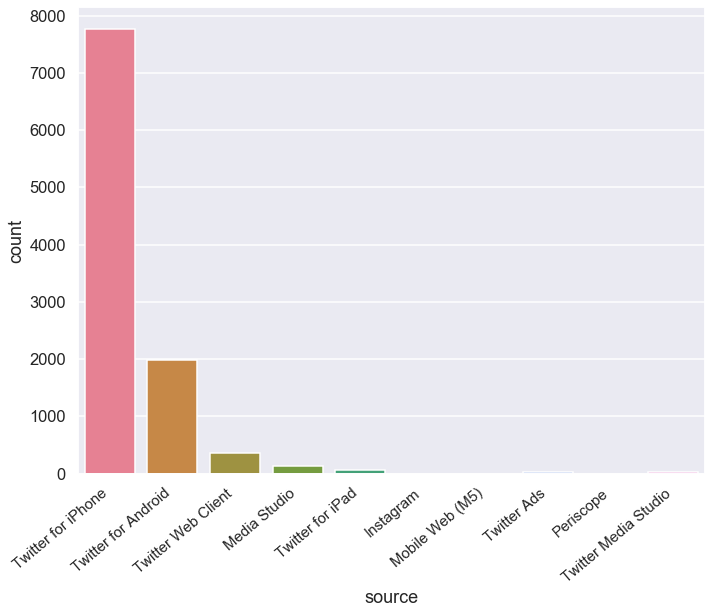

In [66]:
plt.figure(figsize=(10, 8))
num_sources = len(trump.source.unique())
# make a bar plot here

ax=sns.countplot(x= trump['source'], data=trump, palette="husl")
ax.set_xticklabels(ax.get_xticklabels(), fontsize= 15,rotation=40, ha="right");


### Device Usage 

Now that we have cleaned up the `source` field, let's now look at which device Trump has used over the entire time period of this dataset.

To examine the distribution of dates we will convert the date to a fractional year that can be plotted as a distribution.

(Code borrowed from this [link](https://stackoverflow.com/questions/6451655/python-how-to-convert-datetime-dates-to-decimal-years))

In [46]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

trump['year'] = trump['time'].apply(year_fraction)

Overlay the distributions of Trump's 2 most frequently used web technologies over the years. Your final plot should look similar to the plot below:

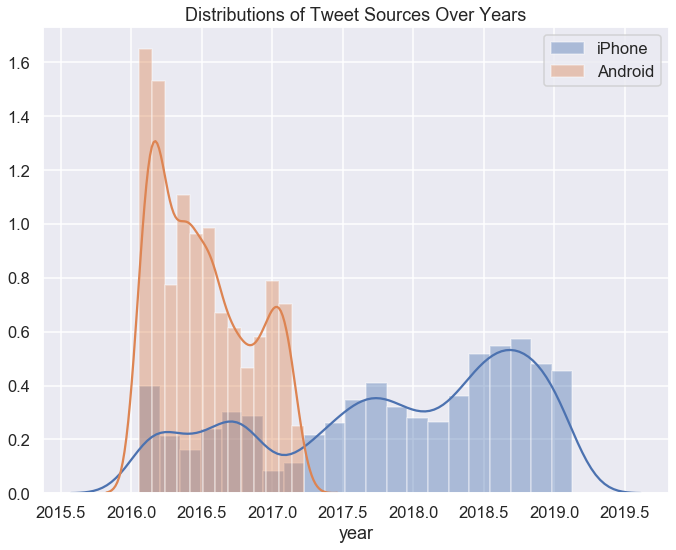

In [65]:
plt.figure(figsize=(10, 8))
device_top2 = trump['source'].value_counts().head(2).index
for device in device_top2:
    sns.distplot(trump[trump['source']==device]['year'])
plt.title("Distributions of Tweet Sources Over Years")
plt.legend(['iPhone', 'Android']);

### Behavior Across Devices


Is there a difference between Trump's tweet behavior across these devices? We will attempt to answer this question in our subsequent analysis.

First, we'll take a look at whether Trump's tweets from an Android device come at different times than his tweets from an iPhone. Note that Twitter gives us his tweets in the [UTC timezone](https://www.wikiwand.com/en/List_of_UTC_time_offsets) (notice the `+0000` in the first few tweets).

In [48]:
for tweet in all_tweets[:3]:
    print(tweet['created_at'])

Wed Oct 12 14:00:48 +0000 2016
Wed Oct 12 13:46:43 +0000 2016
Wed Oct 12 12:59:05 +0000 2016


We'll convert the tweet times to US Eastern Time, the timezone of New York and Washington D.C., since those are the places we would expect the most tweet activity from Trump.

In [49]:
trump['est_time'] = (
    trump['time'].dt.tz_convert("UTC") # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,time,source,text,retweet_count,year,est_time
786204978629185536,2016-10-12 14:00:48+00:00,Twitter for iPhone,PAY TO PLAY POLITICS. \n#CrookedHillary https:...,24915,2016.778689,2016-10-12 09:00:48-05:00
786201435486781440,2016-10-12 13:46:43+00:00,Twitter for iPhone,Very little pick-up by the dishonest media of ...,22609,2016.778689,2016-10-12 08:46:43-05:00
786189446274248704,2016-10-12 12:59:05+00:00,Twitter for Android,Crooked Hillary Clinton likes to talk about th...,18329,2016.778689,2016-10-12 07:59:05-05:00
786054986534969344,2016-10-12 04:04:47+00:00,Twitter for iPhone,Thank you Florida- a MOVEMENT that has never b...,18789,2016.778689,2016-10-11 23:04:47-05:00
786007502639038464,2016-10-12 00:56:06+00:00,Twitter for iPhone,Join me Thursday in Florida &amp; Ohio!\nWest ...,7761,2016.778689,2016-10-11 19:56:06-05:00


#### Hour Column

Add a column called `hour` to the `trump` table which contains the hour of the day as floating point number computed by:

$$
\text{hour} + \frac{\text{minute}}{60} + \frac{\text{second}}{60^2}
$$

* **Hint:** See the cell above for an example of working with [dt accessors](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#basics-dt-accessors). You should use the `est_time` column to calculate the hour.


In [50]:
t = trump['est_time']
trump['hour'] = (t.dt.hour+t.dt.minute/60+ t.dt.second/(60**2))

#### Distribution over Hours of the day, EST

Use this data along with the seaborn `distplot` function to examine the distribution over hours of the day in eastern time that trump tweets on each device for the 2 most commonly used devices.  Your final plot should look similar to the following:

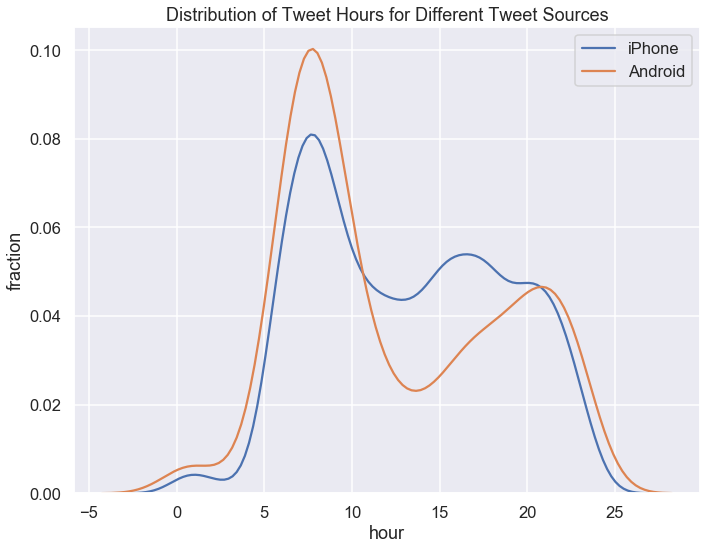

In [64]:
### make your plot here
plt.figure(figsize=(10, 8))
device_top2 = trump['source'].value_counts().head(2).index
for device in device_top2:
    sns.distplot(trump[trump['source']==device]['hour'],label = device,hist = False)
plt.xlabel('hour')
plt.ylabel('fraction')
plt.title("Distribution of Tweet Hours for Different Tweet Sources")
plt.legend(['iPhone', 'Android']);

In [58]:
device_top2[0]

'Twitter for iPhone'

--- 
<br></br>

#### Device Usage over Time Period for Entire Dataset

Let's now look at his tweet device usage over the entire time period we have in the dataset.


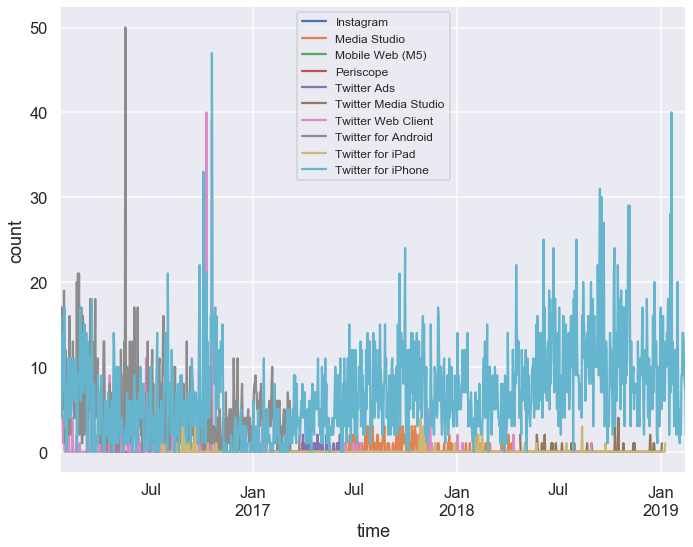

In [90]:
(trump.loc[:, ['est_time', 'source']]
 .set_index('est_time')
 .groupby('source')
 .resample('D')
 .size()
 .unstack(level=0)
 .plot(figsize=(10, 8))
)
plt.xlabel('time')
plt.ylabel('count')
plt.legend(loc='best', prop={'size': 12});


The above plot is overplotted, with too many points to see overall trends in device usage.

I recreate the plot above, changing grouping granularity to by month instead of by day.

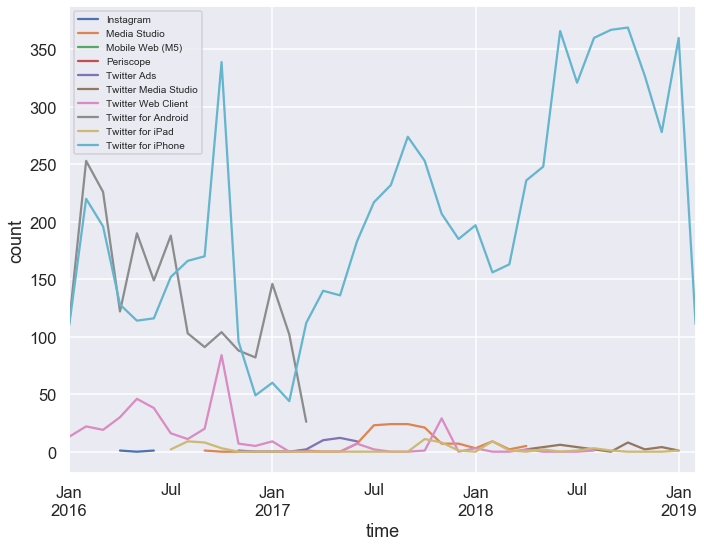

In [97]:
### make your plot here 

(trump.loc[:, ['est_time', 'source']]
 .set_index('est_time')
 .groupby('source')
 .resample('M')
 .size()
 .unstack(level=0)
 .plot(figsize=(10, 8))
)
plt.xlabel('time')
plt.ylabel('count')
plt.legend(loc='best', prop={'size': 10});


#### Device Change in March 2017

According to [this Verge article](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android), Donald Trump switched from an Android to an iPhone sometime in March 2017.

Let's see if this information significantly changes our plot. Create a figure similar to your figure from question 4b, but this time, only use tweets that were tweeted before 2017. Your plot should look similar to the following:


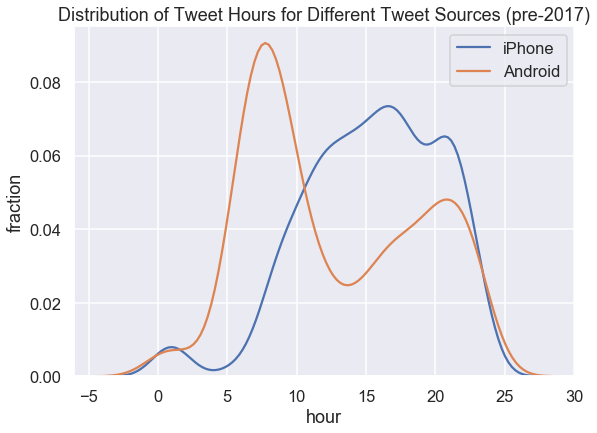

In [69]:
plt.figure(figsize=(8, 6))
pre_switch = trump[trump['year']<2017]

device_top2 = trump['source'].value_counts().head(2).index
for device in device_top2:
    sns.distplot(pre_switch[pre_switch['source']==device]['hour'],hist = False,label=device)
    plt.title("Distribution of Tweet Hours for Different Tweet Sources (pre-2017)")
plt.xlabel('hour')
plt.ylabel('fraction')
plt.legend(['iPhone', 'Android'], loc=1)
plt.show();

#### Insights

During the campaign, it was theorized that Donald Trump's tweets from Android devices were written by him personally, and the tweets from iPhones were from his staff. Does our figure give support to this theory? What kinds of additional analysis could help support or reject this claim?



Yes. We see Android tweets happened earlier in the day and we know this is when Trump tends to tweet. iPhone tweets happen later when staff would be at work and more likely to tweet. We should look into working hours of staff and whether or not they had access to Trump's account. We can also analyze different characteristics of the traits such as writing style, topic, retweet_count trend to see differences from Android to iPhone.



---
# Part 3: Sentiment Analysis

It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [98]:
print(''.join(open("vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



As you can see, the lexicon contains emojis too! Each row contains a word and the *polarity* of that word, measuring how positive or negative the word is.

## Vader Description

The creators of VADER describe the tool’s assessment of polarity, or “compound score,” in the following way:

“The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.”

As you can see, VADER doesn't "read" sentences, but works by parsing sentences into words assigning a preset generalized score from their testing sets to each word separately. 

VADER relies on humans to stabilize its scoring. The creators use Amazon Mechanical Turk, a crowdsourcing survey platform, to train its model. Its training set of data consists of a small corpus of tweets, New York Times editorials and news articles, Rotten Tomatoes reviews, and Amazon product reviews, tokenized using the natural language toolkit (NLTK). Each word in each dataset was reviewed and rated by at least 20 trained individuals who had signed up to work on these tasks through Mechanical Turk. 



Advantage: good simple way for the computer to "understand" and determine polarity. It is a great initial, simple start.

Disadvantage: context matters, and the relationship between the way words are combined can be somewhat lost - the measurement is too general. We lose the nuances of positivity and negativity over 1 sentence, and the positives and negatives can somewhat cancel themselves out. If you have a really long text/data, you probably want more detailed information. 



#### Vader as a df

Read `vader_lexicon.txt` into a DataFrame called `sent`. The index of the DataFrame should be the words in the lexicon. `sent` should have one column named `polarity`, storing the polarity of each word.

* **Hint:** The `pd.read_csv` function may help here. Since the file is tab-separated, be sure to set `sep=\t` in your call to `pd.read_csv`. 


In [99]:
sent = pd.read_csv('vader_lexicon.txt', sep = '\t', usecols=[0,1], 
                   names=['token', 'polarity'], index_col='token')
sent.head()

,polarity
token,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


#### Trump Tweet Overall Sentiment

Now, let's use this lexicon to calculate the overall sentiment for each of Trump's tweets. Here's the basic idea:

1. For each tweet, find the sentiment of each word.
2. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

First, let's lowercase the text in the tweets since the lexicon is also lowercase. Set the `text` column of the `trump` DataFrame to be the lowercased text of each tweet.


In [100]:
trump['text']=trump['text'].str.lower()
trump.head()

,time,source,text,retweet_count,year,est_time,hour
786204978629185536,2016-10-12 14:00:48+00:00,Twitter for iPhone,pay to play politics. \n#crookedhillary https:...,24915,2016.778689,2016-10-12 09:00:48-05:00,9.013333
786201435486781440,2016-10-12 13:46:43+00:00,Twitter for iPhone,very little pick-up by the dishonest media of ...,22609,2016.778689,2016-10-12 08:46:43-05:00,8.778611
786189446274248704,2016-10-12 12:59:05+00:00,Twitter for Android,crooked hillary clinton likes to talk about th...,18329,2016.778689,2016-10-12 07:59:05-05:00,7.984722
786054986534969344,2016-10-12 04:04:47+00:00,Twitter for iPhone,thank you florida- a movement that has never b...,18789,2016.778689,2016-10-11 23:04:47-05:00,23.079722
786007502639038464,2016-10-12 00:56:06+00:00,Twitter for iPhone,join me thursday in florida &amp; ohio!\nwest ...,7761,2016.778689,2016-10-11 19:56:06-05:00,19.935000


Now, let's get rid of punctuation since it will cause us to fail to match words. Create a new column called `no_punc` in the `trump` DataFrame to be the lowercased text of each tweet with all punctuation replaced by a single space. We consider punctuation characters to be *any character that isn't a Unicode word character or a whitespace character*. You may want to consult the Python documentation on regexes for this problem.

(Why don't we simply remove punctuation instead of replacing with a space? See if you can figure this out by looking at the tweet data.)


In [101]:
punct_re = r'[^\s\w]'
trump['no_punc'] = trump['text'].str.replace(punct_re," ")

#### Tweets into Tidy Format

Now, let's convert the tweets into what's called a [*tidy format*](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) to make the sentiments easier to calculate. Use the `no_punc` column of `trump` to create a table called `tidy_format`. The index of the table should be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

The first few rows of our `tidy_format` table look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>num</th>
      <th>word</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>894661651760377856</th>
      <td>0</td>
      <td>i</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>1</td>
      <td>think</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>2</td>
      <td>senator</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>3</td>
      <td>blumenthal</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>4</td>
      <td>should</td>
    </tr>
  </tbody>
</table>

**Note that your DataFrame may look different from the one above.** However, you can double check that your tweet with ID `894661651760377856` has the same rows as ours. Our tests don't check whether your table looks exactly like ours.

As usual, try to avoid using any for loops. Our solution uses a chain of 5 methods on the `trump` DataFrame, albeit using some rather advanced Pandas hacking.

* **Hint 1:** Try looking at the `expand` argument to pandas' `str.split`.

* **Hint 2:** Try looking at the `stack()` method.

* **Hint 3:** Try looking at the `level` parameter of the `reset_index` method.


In [102]:
tidy_format = (
    trump['no_punc'].str.split(expand=True).stack().reset_index(level=1).rename(columns={'level_1':'num',0:'word'})
)

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table. 

Add a `polarity` column to the `trump` table.  The `polarity` column should contain the sum of the sentiment polarity of each word in the text of the tweet.

**Hints:** 
* You will need to merge the `tidy_format` and `sent` tables and group the final answer.
* If certain words are not found in the `sent` table, set their polarities to 0.

In [103]:
trump['polarity'] = (tidy_format.merge(sent,how ='left',left_on= 'word',right_index=True)
                     .reset_index().loc[:,['index','polarity']].groupby('index').sum())
trump['polarity'].fillna(0)

786204978629185536     1.0
786201435486781440    -6.9
786189446274248704     1.8
786054986534969344     1.5
786007502639038464     1.2
                      ... 
1052344365442588673    3.1
1052340597900627968   -0.1
1052270676982333442    5.2
1052268013876064256    1.4
1052268011900555265   -1.9
Name: polarity, Length: 10370, dtype: float64

Now we have a measure of the sentiment of each of his tweets! Note that this calculation is rather basic; you can read over the VADER readme to understand a more robust sentiment analysis.

Now, run the cells below to see the most positive and most negative tweets from Trump in your dataset:

In [104]:
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   the trump portrait of an unsustainable border crisis is dead on. “in the last two years, ice officers made 266,000 arrests of aliens with criminal records, including those charged or convicted of 100,000 assaults, 30,000 sex crimes &amp; 4000 violent killings.” america’s southern....

   it is outrageous that poisonous synthetic heroin fentanyl comes pouring into the u.s. postal system from china. we can, and must, end this now! the senate should pass the stop act – and firmly stop this poison from killing our children and destroying our country. no more delay!

   the rigged russian witch hunt goes on and on as the “originators and founders” of this scam continue to be fired and demoted for their corrupt and illegal activity. all credibility is gone from this terrible hoax, and much more will be lost as it proceeds. no collusion!

   ...this evil anti-semitic attack is an assault on humanity. it will take all of us working together to extract the poison of an

In [105]:
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   congratulations to patrick reed on his great and courageous masters win! when patrick had his amazing win at doral 5 years ago, people saw his great talent, and a bright future ahead. now he is the masters champion!

   congratulations to a truly great football team, the clemson tigers, on an incredible win last night against a powerful alabama team. a big win also for the great state of south carolina. look forward to seeing the team, and their brilliant coach, for the second time at the w.h.

   my supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history. it is a beautiful thing to watch as we win elections and gather support from all over the country. as we get stronger, so does our country. best numbers ever!

   thank you to all of my great supporters, really big progress being made. other countries wanting to fix crazy trade deals. economy is roaring. supreme court pick getting great reviews. new

#### Analysis of Sentiment Analysis
Some of the words are negative, but the overall message might be positive i.e. negative tweet 2, a call to action to stop illegal drugs entering the US. The same goes for negative tweet 4, calling for unity against hate. 

The positive tweets seem to be accurately represented.


Now, we create a `distplot` of the sentiments. 

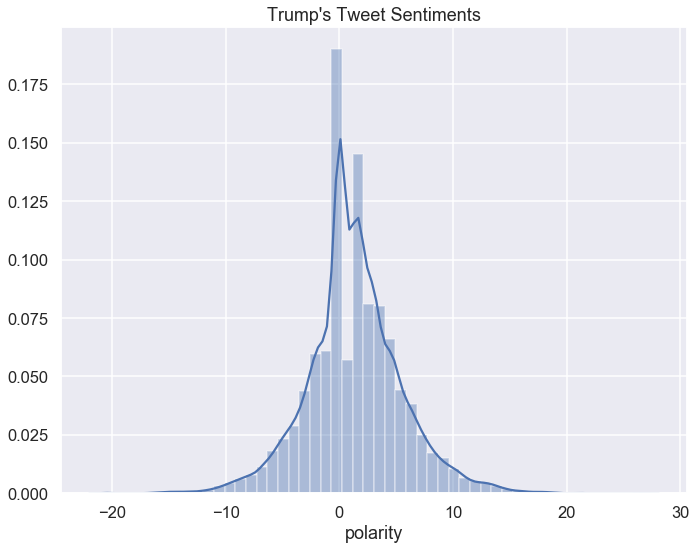

In [127]:
plt.figure(figsize=(10, 8))
plt.title("Trump's Tweet Sentiments")
sns.distplot(trump['polarity'], color= 'b');

#### Election and Inaugaration Dates Polarity

I want to see how polarity changes with two important dates. 
<br>
-`ELEC_DATE` is the date when Trump won the 2016 Presidential election
<br>
-`INAUG_DATE` is the date that Trump was sworn into office.

I create a line plot of the sentiment of Trump's tweets over time. Plot the mean sentiment of two weeks' of his tweets over time. Then, plot vertical lines corresponding to his election and inauguration dates. 

In [123]:
from datetime import datetime


ELEC_DATE = datetime(2016, 11, 8)
INAUG_DATE = datetime(2017, 1, 20)

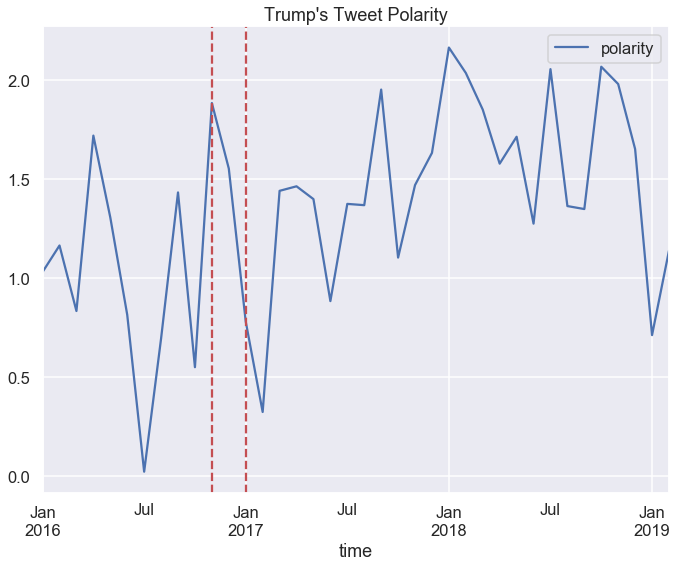

In [126]:
(trump.loc[:, ['est_time', 'polarity']]
 .set_index('est_time')
 .resample('M')
 .mean()
 .plot(figsize=(10, 8)) 
)
plt.xlabel('time')
plt.title("Trump's Tweet Polarity")
plt.axvline(x= pd.to_datetime(ELEC_DATE), color= 'r', linestyle='dashed')
plt.axvline(x= pd.to_datetime(INAUG_DATE), color= 'r', linestyle='dashed');


We see that around the time of his election, the polarity of Trump's tweets was a significantly higher than during the time of his inaugaration. About a month after his inaugaration, there was a sharp increase in his tweet polarity, and it increased steadily until January 2018, when it took another dip. 


### Election and Inaugaration Dates Mentions of "Fake News"

The phrase "fake news" is apparently really popular! We can conclude that Trump's tweets containing "fake" and/or "news" result in the most retweets relative to words his other tweets. Or can we?

Let's investigate the term "fake news". Create a table called `fake_counts` that has two columns:

1. `fake_news`: The number of tweets containing the term "fake news".
1. `total`: The total number of tweets for the time period.

The index of the table should be datetimes for each two-week period in the data.


In [172]:
trump['fakenews']= trump['no_punc'].str.contains('fake news')
fake_counts= trump.apply(lambda x: 'fake news' in x.text, axis=1).astype(int).to_frame(
).join(trump[['time', 'text']])
fake_counts.columns=['fake_news', 'time', 'total']
fake= fake_counts.set_index('time').resample(rule='2W', closed='left').sum()['fake_news']
other= fake_counts.set_index('time').resample(rule='2W', closed='left').count()['total']

fake_counts = pd.DataFrame({'fake_news': fake, 'total': other})
fake_counts

,fake_news,total
time,,
2016-01-31 00:00:00+00:00,0,217
2016-02-14 00:00:00+00:00,0,211
2016-02-28 00:00:00+00:00,0,259
2016-03-13 00:00:00+00:00,0,224
2016-03-27 00:00:00+00:00,0,210
...,...,...
2018-12-30 00:00:00+00:00,9,138
2019-01-13 00:00:00+00:00,11,139
2019-01-27 00:00:00+00:00,13,190


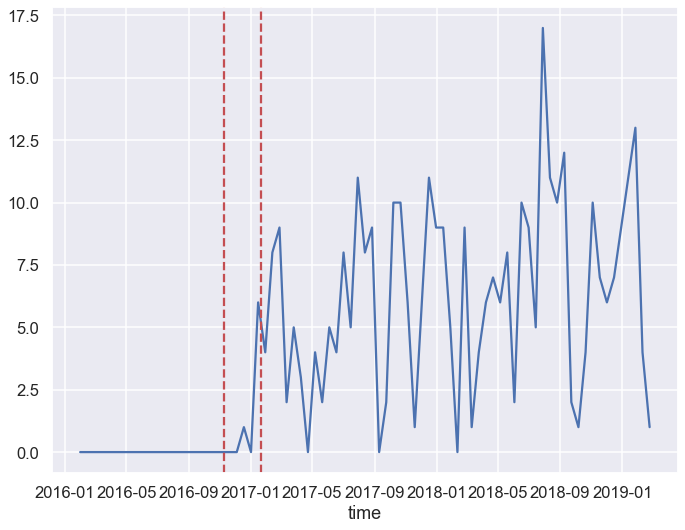

In [173]:
plt.plot(fake)
plt.xlabel('time')
plt.axvline(x= pd.to_datetime(ELEC_DATE), color= 'r', linestyle='dashed')
plt.axvline(x= pd.to_datetime(INAUG_DATE), color= 'r', linestyle='dashed');

Usage of the term "fake news" significantly increases between election and inaugaration, and has spiked up and down ever since. This may be correlated with any news release events that upset him, so he asserts these articles are false and "fake news".


### Distributions of Sentiments for tweets containing certain keywords

In the cell below, create a single plot showing both the distribution of tweet sentiments for tweets containing `nytimes`, as well as the distribution of tweet sentiments for tweets containing `fox`.

Be sure to label your axes and provide a title and legend. Your colors don't have to match ours, but you should use different colors for `fox` and `nytimes`.

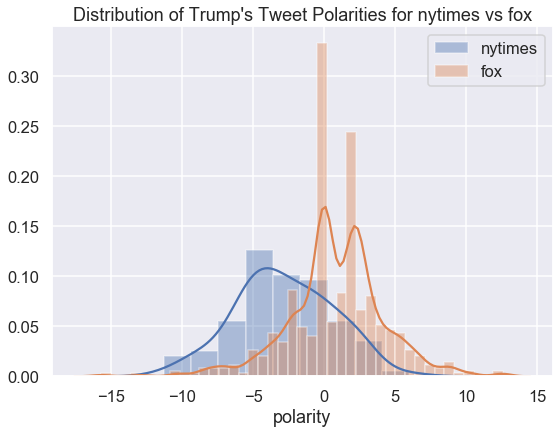

In [133]:
word1 = 'nytimes'
word2 = 'fox'

distr1 = trump[trump['text'].str.lower().str.contains(word1)]['polarity']
distr2= trump[trump['text'].str.lower().str.contains(word2)]['polarity']

sns.distplot(distr1,label=word1)
sns.distplot(distr2,label=word2)
plt.title("Distribution of Trump's Tweet Polarities for " + word1 + ' vs ' + word2)
plt.legend();

We see Trump has more positive Tweets about Fox than the New York Times. Interesting.

Now, I explore other interesting word pairs.

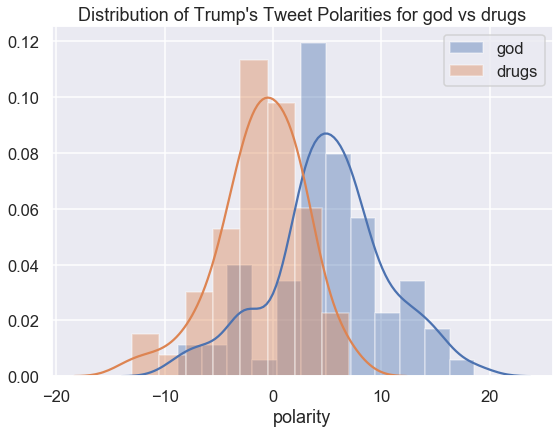

In [134]:
plt.figure(figsize=(8, 6))
word1 = 'god'
word2 = 'drugs'

distr1 = trump[trump['text'].str.lower().str.contains(word1)]['polarity']
distr2= trump[trump['text'].str.lower().str.contains(word2)]['polarity']

sns.distplot(distr1,label=word1)
sns.distplot(distr2,label=word2)
plt.title("Distribution of Trump's Tweet Polarities for " + word1 + ' vs ' + word2)
plt.legend();

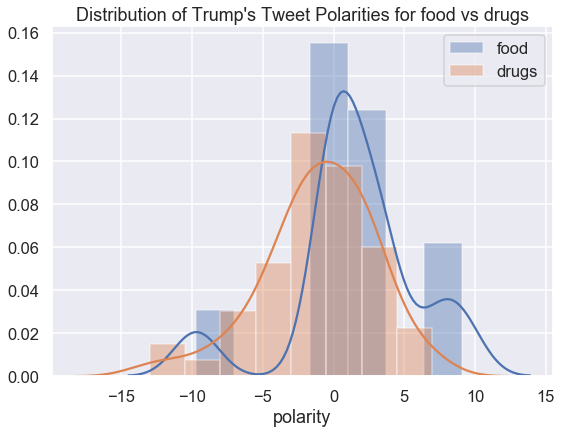

In [136]:
plt.figure(figsize=(8, 6))
word1 = 'food'
word2 = 'drugs'

distr1 = trump[trump['text'].str.lower().str.contains(word1)]['polarity']
distr2= trump[trump['text'].str.lower().str.contains(word2)]['polarity']

sns.distplot(distr1,label=word1)
sns.distplot(distr2,label=word2)
plt.title("Distribution of Trump's Tweet Polarities for " + word1 + ' vs ' + word2)
plt.legend();

There seem to be more positive tweets about drugs than god, and more positive tweets for drugs than fod food - a funny phenomenon.

Now, let's see whether there's a difference in sentiment for tweets with hashtags and those without.

### Sentiments for with and without hashtags/links 

First, we'll need to write some regex that can detect whether a tweet contains a hashtag or a link. We say that:

- A tweet is a retweet if it has the string 'rt' anywhere in the tweet if it is preceeded and followed by a non-word character (the start and end of the string count as non-word characters).
- A tweet has a hashtag if it has the character '#' anywhere in the tweet followed by a letter.
- A tweet contains a link or a picture if it has `http` anywhere in the tweet

(You can check out Trump's Twitter for why these criteria are true).

In the cell below, assign `rt_re` to a regex pattern that identifies retweets and `hash_link_re` to a regex pattern that identifies tweets with hashtags or links.

**Hints**: 
- Be sure to precede your regex pattern with `r` to make it a raw string (Ex: `r'pattern'`). To find out more, you can read the first paragraph of the [documentation](https://docs.python.org/2/library/re.html).
- You may find using regex word boundaries helpful for one of your patterns. 

In [143]:
rt_re = r'\brt\b' #r'[^/b]rt[^/b]'
hash_link_re = r'#\b|http\b'

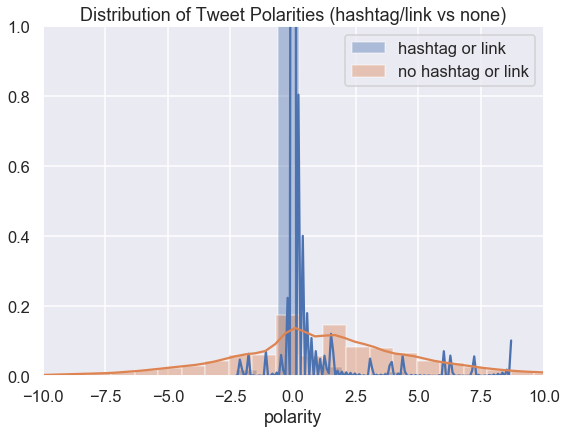

In [152]:
sns.distplot(trump[trump['text'].str.match(hash_link_re)]['polarity'],label='hashtag or link');
sns.distplot(trump[~trump['text'].str.match(hash_link_re)]['polarity'],label='no hashtag or link');
plt.xlim(-10, 10)
plt.ylim(0, 1)
plt.title('Distribution of Tweet Polarities (hashtag/link vs none)');
plt.legend();

Tweets with hashtag or links have more neutral polarity, the mode is higher and centered around 0, the distribution is unimodal.

For no hashtag or link, there is much more spread, and it is bimodal. 

--- 

### Engagement

---
<br></br>


Which of Trump's tweets had the most retweets? Were there certain words that often led to more retweets?

We can find this out by using our `tidy_format` DataFrame. For each word in the `tidy_format` DF, find out the number of retweets that its tweet got. Filter out words that didn't appear in at least 25 tweets, find out the median number of retweets each word got, and save the top 20 most retweeted words into a DataFrame called `top_20`. Your `top_20` table should have this format:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>retweet_count</th>
    </tr>
    <tr>
      <th>word</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>fake</th>
      <td>22963.0</td>
    </tr>
    <tr>
      <th>news</th>
      <td>20463.0</td>
    </tr>
    <tr>
      <th>ds100</th>
      <td>20432.0</td>
    </tr>
    <tr>
      <th>great</th>
      <td>20159.0</td>
    </tr>
    <tr>
      <th>class</th>
      <td>20121.0</td>
    </tr>
  </tbody>
</table>

In [161]:
sort= tidy_format.join(trump).drop(labels= 
        ['time', 'source', 'text', 'est_time', 'hour', 'no_punc', 'polarity'], axis=1)
sort= sort.reset_index().drop('index', 1)
sort.head()

,num,word,retweet_count,year
0,0,bigop1,1059,2016.054645
1,1,realdonaldtrump,1059,2016.054645
2,2,sarahpalinusa,1059,2016.054645
3,3,https,1059,2016.054645
4,4,t,1059,2016.054645


In [166]:
word_counts= pd.Series(tidy_format.groupby('word').size())
gr_25tweets= word_counts[word_counts>=25]
gr_25tweets= gr_25tweets.index

temp= tidy_format[tidy_format['word'].isin(gr_25tweets)]
temp1= temp.join(trump['retweet_count'])
temp1= temp1[['word', 'retweet_count']]

temp1= temp1.groupby('word').median()
top_20= temp1.sort_values('retweet_count', ascending= False)
top_20= top_20[:20]
top_20

,retweet_count
word,
illegally,29991.0
human,29673.0
christmas,29308.5
mccabe,28195.0
kavanaugh,27248.5
mainstream,26797.0
immigrants,26067.0
lowest,26015.5
crimes,25526.0


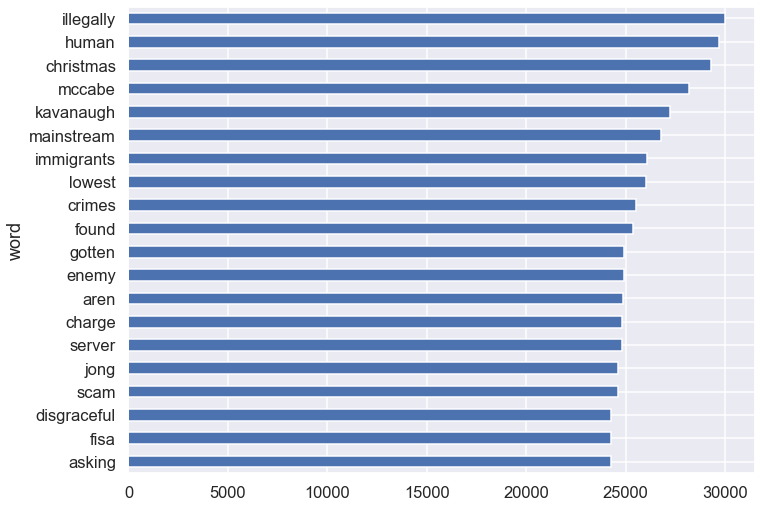

In [168]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8));

In [ ]:
plt.figure(figsize=(10, 8))